In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import smart_resize

from keras.models import Model
#import keras_cv

/home/zuko39/envis/rcp_208/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-21 22:19:43.821396: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-21 22:19:43.825547: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-21 22:19:43.835578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742591983.851790   42836 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742591983.856447   42836 cuda_blas.cc:1418] U

In [2]:
from utils import convert_label_list, compute_anchors, produce_crop_list, compute_iou, matching_boxes

## charger les données

In [3]:
training_dataset = tfds.load(
    "voc/2007",
    split="train",
    shuffle_files=False,
)
validation_dataset = tfds.load(
    "voc/2007",
    split="validation",
    shuffle_files=False,
)
test_dataset = tfds.load(
    "voc/2007",
    split="test",
    shuffle_files=False,
)
len(training_dataset), len(validation_dataset), len(test_dataset)

2025-03-21 22:19:52.520909: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


(2501, 2510, 4952)

## We need to create class background if we want to distinguish object from background

Format: [x_min, y_min, x_max, y_max]

Format: [x_topleft, y_topleft, x_bottomright, y_bottomright]

on doit : resize les images,
resize les coordonnées des bbox,
les labels = les numeros de labels, 
etiquettes 
et coordonnées des bbox

In [4]:
with open("/home/zuko39/tensorflow_datasets/voc/2007/4.0.0/labels.labels.txt") as file:
    lignes = [line.rstrip() for line in file]
indexes = [i for i in range(len(lignes))]
zip_label_line = zip(indexes, lignes)
d = dict(zip_label_line)

for i, j in d.items():
    print(i, j)

0 aeroplane
1 bicycle
2 bird
3 boat
4 bottle
5 bus
6 car
7 cat
8 chair
9 cow
10 diningtable
11 dog
12 horse
13 motorbike
14 person
15 pottedplant
16 sheep
17 sofa
18 train
19 tvmonitor


2025-03-21 22:19:59.228340: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


data cléées: dict_keys(['image', 'image/filename', 'labels', 'labels_no_difficult', 'objects'])
data.objects cléées:dict_keys(['bbox', 'is_difficult', 'is_truncated', 'label', 'pose']), <class 'dict_keys'>
data.objects.label:[14 14 12 12 12], <class 'tensorflow.python.framework.ops.EagerTensor'>

data.objects.bbox:[[0.35       0.5933735  0.616      0.8493976 ]
 [0.324      0.18674698 0.608      0.44879517]
 [0.424      0.6385542  0.694      0.78313255]
 [0.442      0.23493975 0.678      0.39759037]
 [0.46       0.7981928  0.538      0.85542166]], <class 'tensorflow.python.framework.ops.EagerTensor'>


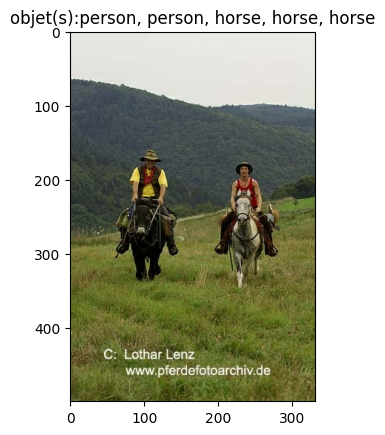

In [5]:
for data in training_dataset.shuffle(len(training_dataset)): #for one img
    print(f"data cléées: {data.keys()}")
    print(f"data.objects cléées:{data['objects'].keys()}, {type(data['objects'].keys())}")
    print(f"data.objects.label:{data['objects']['label']}, {type(data['objects']['label'])}") #returns a tensor listing the labels
    print()
    print(f"data.objects.bbox:{data['objects']['bbox']}, {type(data['objects']['bbox'])}")
    plt.imshow(data['image'])
    title = "objet(s):"
    for object in data['objects']['label']:
        title += f"{d[object.numpy()]}, "
    plt.title(title[:-2]);
    
    break

2025-03-21 22:38:52.341774: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


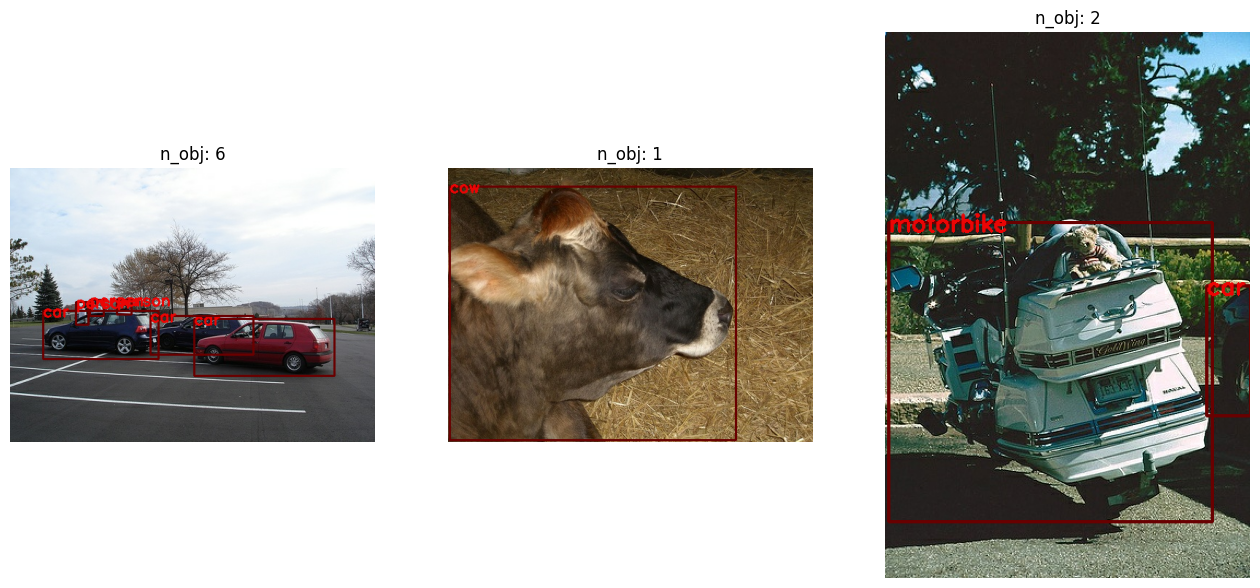

In [19]:
fig = plt.figure(figsize=(16, 10))

for idx, data in enumerate(training_dataset.shuffle(len(training_dataset)).take(3)): #for each 3 images
    fig.add_subplot(1, 3, idx+1)
    img = np.array(data['image'])
    y, x, _ = img.shape
    for idx2, objet in enumerate(data['objects']['label']): #for each object
        ymin, xmin, ymax, xmax = data['objects']['bbox'][idx2].numpy()
        im = cv2.rectangle(img, (int(xmin*x), int(ymin*y)), (int(xmax*x), int(ymax*y)), color=(105,0,0), thickness=2) #a rect for each objet
        etiquette = d[objet.numpy()] # add 1 so object corresponds to labels
        cv2.putText(im, etiquette, (int(xmin*x), int(ymin*y+8)), cv2.FONT_HERSHEY_SIMPLEX, .7, (235,5,5), 2)
    plt.axis("off")
    plt.title(f"n_obj: {len(data['objects']['label'])}")
    plt.imshow(img)

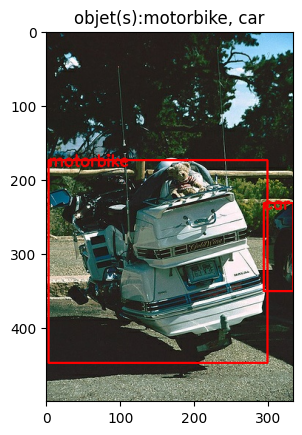

In [20]:
image = np.array(data['image'])
y, x, _ = image.shape
title = "objet(s):"

for index, objet in enumerate(data['objects']['label']): #for each object
    ymin, xmin, ymax, xmax = data['objects']['bbox'][index].numpy()
    img = cv2.rectangle(image, (int(xmin*x), int(ymin*y)), (int(xmax*x), int(ymax*y)), color=(255,0,0), thickness=2)
    cv2.putText(img, d[objet.numpy()], (int(xmin*x), int(ymin*y+8)), cv2.FONT_HERSHEY_SIMPLEX, .7, (235,5,5), 2)
    
    title += f"{d[objet.numpy()]}, "
plt.imshow(img)
plt.title(title[:-2]);
#plt.show()

In [ ]:
roi_pos_l = []
roi_neg_l = []

labels_pos = []
labels_back = []

liste_pos = [] #une liste de listes (matchs par images) en aura-t-on besoin plus tard?
liste_back = [] #une liste de listes (backg par images)

#on fait deux listes de listes : des sous listes par images avec les coord des gt bbox 
#et les coord des predictions pour pouvoir mesurer IoU et determiner si c'est des ROI positives ou negatives

for idx, data in enumerate(tqdm(training_dataset)): #for each image
    img = np.array(data['image'])
    y, x, _ = data['image'].shape
    roi = produce_crop_list(data['image'], compute_anchors(data['image'])) #list of predictions (tuples) for one img
    roi_coord = []
    gt_list_img = []
    
    roi_pos = [] #pr une image quelles sont les roi objets?
    roi_back = []   
    for _, i in roi:
        roi_coord.append(i)
        
    for idx2, objet in enumerate(data['objects']['label']): #for each object
        ymin_n, xmin_n, ymax_n, xmax_n = data['objects']['bbox'][idx2].numpy()
        bbox_gt= convert_label_list(ymin_n*y, xmin_n*x, ymax_n*y, xmax_n*x) #gt coord
        gt_list_img.append(bbox_gt) #une liste de coord pour chaque objet

    pos = matching_boxes(roi_coord, gt_list_img, 0.2)[0] #une liste de matches pour une img
    back = matching_boxes(roi_coord, gt_list_img, 0.2)[1] #une liste de 2 roi background pr une img
    
    if len(pos) > 0: #si on a un/+ match
        for j in pos:
            idx_tuple, iou, coord = j
            roi_pos = img.copy()[int(coord[1]-coord[3]/2):int(coord[1]+coord[3]/2),int(coord[0]-coord[2]/2):int(coord[0]+coord[2]/2)]
            roi_pos_l.append(cv2.resize(roi_pos, (224,224)))
            label = data['objects']['label'].numpy()[idx_tuple[1]]
            labels_pos.append(label) #on applatit la structure qui etait nested car les roi sont mtnt les examples
            
    if len(back) > 0: #si on a un background
        for k in back:
            _, _, c = k
            roi_neg = img.copy()[int(c[1]-c[3]/2):int(c[1]+c[3]/2),int(c[0]-c[2]/2):int(c[0]+c[2]/2)]
            roi_neg_l.append(cv2.resize(roi_neg, (224,224)))
            label_b = 20
            labels_back.append(label_b)
    liste_pos.append(pos)
    liste_back.append(back)

In [ ]:
d[20] = 'background' #on update le dict

In [ ]:
fig = plt.figure(figsize=(10, 10)) #exemples de background
for idx, i in enumerate(roi_neg_l[:10]):
    fig.add_subplot(2, 5, idx+1)
    plt.imshow(i)
plt.show()

NameError: name 'liste_pos' is not defined

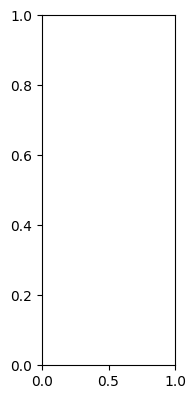

In [7]:
fig = plt.figure(figsize=(10, 10))
for idx, data in enumerate(training_dataset.take(10)):
    fig.add_subplot(2, 5, idx+1)
    copy3 = np.array(data['image']).copy()
    c = 0
    if len(liste_pos[idx]) > 0 :
        for idx2, objet in enumerate(liste_pos[idx]):
            inex, iou, coord = objet
            xmid, ymid, w, h = coord
            im = cv2.rectangle(copy3, (int(xmid - w/2), int(ymid - h/2)), (int(xmid + w/2), int(ymid + h/2)), color=(255,0,0), thickness=2)
            #le deuxieme indice du tuple inex retourne par matching_boxes() etait le rang du label
            cv2.putText(im, f"{iou}, {d[data['objects']['label'].numpy()[inex[1]]]}", (int(xmid - w/2+9), int(ymid - h/2-2)), cv2.FONT_HERSHEY_SIMPLEX, .7, (235,5,5), 2)
            c += 1
        plt.title(f"roi positive/s\n ({c} intersections)")
        plt.imshow(im)
    else:
        plt.title(f"no positive roi ({c} intersections)")
plt.show()

In [ ]:
liste_imgs = roi_pos_l + roi_neg_l
liste_labels = labels_pos + labels_back

In [ ]:
d_size = 2048
batch_size = 16

In [ ]:
# Identically shuffle the train and test datasets, récupéré d'un TP de RCP 209
if len(liste_imgs) == len(liste_labels):
    p = np.random.permutation(len(liste_imgs))
else:
    print('problem')

for idx, i in enumerate(p):
    liste_imgs[idx] = liste_imgs[i]
    liste_labels[idx] = liste_labels[i]

In [ ]:
for i, j in zip(liste_imgs, liste_labels):
    plt.imshow(i)
    plt.title(f"{d[j]}")
    break

In [ ]:
dataset_i = tf.data.Dataset.from_tensor_slices(np.array(liste_imgs)) #cette ligne cause de freeze du laptop... 
dataset_l = tf.data.Dataset.from_tensor_slices(liste_labels)
ds = tf.data.Dataset.zip((dataset_i, dataset_l))
ds = ds.batch(batch_size) #on ne verifie pas la proportion des images back en relation avec les images d'objets

## On fait le modèle

In [ ]:
model = ResNet50(include_top=True, weights='imagenet')
model = Model(inputs=model.input, outputs=model.layers[-2].output) #on retire le classifieur de imagent

## On entraîne le nouveau classifieur apres transfert par initialisation avec ImageNet

In [ ]:
fc1 = layers.Dense(32, activation="relu")(model.output)
fc1 = keras.layers.Dropout(0.7)(fc1)
fc2 = Dense(21,activation='softmax')(fc1) #20 classes + back
model = Model(inputs=model.input, outputs=fc2)

for layer in model.layers[:-9]:
    layer.trainable = False
    
#recompile bc we changed the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy' ,
              metrics=['accuracy']
             )

#training
model.load_weights("/home/zuko/environments/projet/poids.weights.h5")
#model.fit(ds, epochs=1) 

In [ ]:
#model.fit(ds, epochs=1) 

In [ ]:
#model.save_weights("/home/zuko/environments/projet/poids.weights.h5", overwrite=True)

## On a une accuracy > 0.5 en train après 2 epochs avec un ResNet50 pre entrainé sur ImageNet
et dont seules les couches profondes aussi "hautes" ou plus que la dernière couche convolutive (conv5_block3_3_conv)
sont entraînées
on a fit tout le train set, on ne test pas les resultats sur un autre set de données car c'est seulement une étape intermédiaire

## Inférence

In [ ]:
liste_match = [] #une liste de listes 

for idx, data in enumerate(tqdm(validation_dataset.take(100))): #for each image
    img = np.array(data['image'])
    y, x, _ = data['image'].shape
    roi = produce_crop_list(data['image'], compute_anchors(data['image'])) #list of predictions (tuples) for one img
    roi_coord = [] #ok
    gt_list_img = [] #ok
    roi_match = []  
    for _, i in roi:
        roi_coord.append(i)
        
    for idx2, objet in enumerate(data['objects']['label']): #for each object
        ymin_n, xmin_n, ymax_n, xmax_n = data['objects']['bbox'][idx2].numpy()
        bbox_gt= convert_label_list(ymin_n*y, xmin_n*x, ymax_n*y, xmax_n*x) #gt coord
        gt_list_img.append(bbox_gt) #une liste de coord pour chaque objet
    #y a t il un/+ match?
    pos = matching_boxes(roi_coord, gt_list_img, 0.36)[0] #on augmente un peu le seuil de IoU de match
    
    if len(pos) > 0: #si on a un/+ match
        for j in pos:
            idx_tuple, iou, coord = j
            label = data['objects']['label'].numpy()[idx_tuple[1]] #vrai label
            roi_pos = img.copy()[int(coord[1]-coord[3]/2):int(coord[1]+coord[3]/2),int(coord[0]-coord[2]/2):int(coord[0]+coord[2]/2)]
            
            pred = model.predict(smart_resize(roi_pos,(224,224)).reshape(-1, 224, 224, 3))
            pred_index = int(np.argmax(pred, axis=1))
            if pred_index != 20: 
                roi_match.append((pred_index, pred[0][pred_index], iou, coord))
            else:
                pass   
    liste_match.append(roi_match)

In [ ]:
liste_match[:25]

In [ ]:
fig = plt.figure(figsize=(12, 10))
for idx, data in enumerate(validation_dataset.take(25)):
    copy3 = np.array(data['image']).copy()
    c = 0
    fig.add_subplot(5, 5, idx+1)
    if len(liste_match[idx]) > 0 :
        
        for idx2, objet in enumerate(liste_match[idx]):
            pred, proba, iou, coord = objet
            xmid, ymid, w, h = coord
            im = cv2.rectangle(copy3, (int(xmid - w/2), int(ymid - h/2)), (int(xmid + w/2), int(ymid + h/2)), color=(255,0,0), thickness=2)
            cv2.putText(im, f"{iou}, {d[pred]}", (int(xmid - w/2+9), int(ymid - h/2+9)), cv2.FONT_HERSHEY_SIMPLEX, .5, (235,5,5), 2)
            c += 1
            plt.title(f"roi positive/s\n ({c} intersections)")
            plt.imshow(im)
plt.show()

In [ ]:
#mettre img qui ont une seule classe d'objet ds une liste
counter = 0
liste_labels = []
liste_imgs = []
for data in tqdm(training_dataset):
    if len(data['labels']) == 1:
        counter +=1
        liste_labels.append(data['labels'][0].numpy())
        liste_imgs.append(smart_resize(data['image'],(224,224)))
print(f"we have :{counter} images with only one class of object/s")
liste_labels[:10], len(liste_labels)

## On fait la même chose pour les images de test

In [ ]:
counter = 0
liste_labels2 = []
liste_imgs2 = []
for data in tqdm(test_dataset):
    if len(data['labels']) == 1:
        counter +=1
        liste_labels2.append(data['labels'][0].numpy())
        liste_imgs2.append(smart_resize(data['image'],(224,224)))
print(f"we have :{counter} images with only one class of object/s")
liste_labels2[:10], len(liste_labels2)

In [ ]:
liste_labels = liste_labels + liste_labels2
liste_imgs = liste_imgs + liste_imgs2

In [ ]:
for idx, (i, j) in enumerate(zip(liste_imgs, liste_labels)):
    plt.imshow(smart_resize(i,(224,224)))
    plt.title(f"{d[j]}")
    break

## On fait le dataset pour pouvoir utiliser ResNet50 en prediction : extraire descripteurs

Cette étape est exporatoire + prépare une alternative à l'entrainnement du *SVM* proposé par **Girschik et. al** dans l'article R-CNN

In [ ]:
d_size = 2048
batch_size = 16

In [ ]:
dataset_i = tf.data.Dataset.from_tensor_slices(liste_imgs)
dataset_l = tf.data.Dataset.from_tensor_slices(liste_labels)
ds = tf.data.Dataset.zip((dataset_i, dataset_l))
ds = ds.batch(batch_size)

In [ ]:
y_train = np.zeros(len(liste_labels), dtype="uint8")
descript = np.zeros((len(liste_labels), d_size), dtype="float32")
y_train.shape, descript.shape

In [ ]:
for idx, (i, j) in enumerate(tqdm(ds)): # cette cellule mets presque 6 min à executer en CPU sur mon laptop
    descript[idx*batch_size:(idx+1)*batch_size] = model.predict(i, verbose=False)
    y_train[idx*batch_size:(idx+1)*batch_size] = j

In [ ]:
output_file = 'deepfeatures_resnet50_voc2007' #on sauve les matrices
np.savez(output_file, X_train=descript, y_train=y_train)
                      #X_test=descript_2, y_test=y_test)

In [ ]:
from sklearn.manifold import TSNE

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
      
tsne = TSNE(n_components=3, perplexity=75, init='random')
embedding = tsne.fit_transform(descript)
scatter = ax.scatter(embedding[:,0], embedding[:,1], embedding[:,-1], c=y_train, marker='o', alpha=0.4)
ax.view_init(elev=15, azim=70)
ax.legend(*scatter.legend_elements())
i = None
for i in np.arange(0, embedding.shape[0], 60):
    ax.text(embedding[i,0], embedding[i,1], embedding[i,2], s=d[y_train[i]])

plt.show()

certaines descripteurs d'une même classe ne s'agglomèrent pas ensemble : exemple "bottle", d'autres, si exemples : "cat, bird, train... "

## On peut ***entraîner*** les couches les plus profondes du modèle, il faut ajouter un classifieur
Nota : il n'y a pas de classe "background" dans notre entrainement

### Unlike an SVM, ### 
whose weights are trained seperately from the CNN backbone, we attempt to have a head that learns with the backbone so the pretraining on the voc 2007 classes is not as important as in the **Girschick et al.** paper. Also we don't have a GPU so 2 epochs are deemed sufficiant. 

In [ ]:
train_ds = tfds.load(
    "voc/2007",
    split="train",
    batch_size=batch_size,
    shuffle_files=True,
)
val_ds = tfds.load(
    "voc/2007",
    split="validation",
    batch_size=batch_size,
    shuffle_files=True,
)

In [ ]:
from tensorflow.keras.metrics import Metric

iou = tf.keras.metrics.MeanIoU(20)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy' ,
              metrics=['accuracy', iou]
             )

In [ ]:
batch_count = 0
for idx, (i, j) in enumerate(tqdm(zip(liste_imgs, liste_labels))):
    y_train[idx] = j
    images[idx] = np.stack(smart_resize(i,(224,224)))
    
    if (idx+1) % batch_size == 0:
        image_batch = images[batch_count*batch_size:(batch_count+1)*batch_size].reshape(-1, 224, 224, 3)
        descript[batch_count*batch_size:(batch_count+1)*batch_size] = model.predict(image_batch, verbose=False)
        batch_count += 1
        images = None #reset
if type(images) != type(None):
    last_batch = images[batch_count*batch_size:].reshape(-1, 224, 224, 3)
    descript[batch_count*batch_size:] = model.predict(last_batch, verbose=False)
    images = None

In [ ]:
d_size = 2048
batch_size = 16
X_train = np.zeros((len(liste_labels), d_size), dtype="float32")
y_train = np.zeros(len(liste_labels), dtype="uint8")

for idx, (i, j) in enumerate(tqdm(zip(liste_imgs, liste_labels))):
    pred = model(smart_resize(i,(224,224)).reshape(-1, 224, 224, 3))
X_train[idx*batch_size:(idx+1)*batch_size] = pred
y_train[idx*batch_size:(idx+1)*batch_size] = j

In [ ]:
len(liste_imgs) == len(liste_labels)

In [ ]:
fig = plt.figure(figsize=(16, 6))
for idx, data in enumerate(training_dataset.shuffle(len(training_dataset)).take(5)):
    fig.add_subplot(1, 5, idx+1)
    plt.imshow(data['image'])
    plt.axis("off")
    plt.title(f"n of objects: {data['objects']['bbox'].shape[0]} \n shape:{data['image'].shape[:2]}")# data['objects'] is a dict
plt.show()

In [ ]:
#loopy loop to investigate data : are bbox coordinates normalized? seems so
counter = 0
for i in training_dataset.shuffle(len(training_dataset)).take(10): 
    #y, x, _ = i['image'].shape 
    for box in i['objects']['bbox']: #sample 1st object
        for val in box:
            if val < 0 or val > 1:
                print("problem")
            else :
                counter +=1
                pass
print(f"nb of coordinates tested:{counter}, {int(counter/4)} boxes")

In [ ]:
fig = plt.figure(figsize=(16, 10))

for idx, data in enumerate(training_dataset.shuffle(len(training_dataset)).take(3)): #for each 3 images
    fig.add_subplot(1, 3, idx+1)
    img = np.array(data['image'])
    y, x, _ = img.shape
    for idx2, objet in enumerate(data['objects']['label']): #for each object
        ymin, xmin, ymax, xmax = data['objects']['bbox'][idx2].numpy()
        im = cv2.rectangle(img, (int(xmin*x), int(ymin*y)), (int(xmax*x), int(ymax*y)), color=(105,0,0), thickness=2) #a rect for each objet
        etiquette = d[objet.numpy()] # add 1 so object corresponds to labels
        cv2.putText(im, etiquette, (int(xmin*x), int(ymin*y+8)), cv2.FONT_HERSHEY_SIMPLEX, .7, (235,5,5), 2)
    plt.axis("off")
    plt.title(f"n_obj: {len(data['objects']['label'])}")
    plt.imshow(img)

In [ ]:
#pred = model.predict(smart_resize(image,(224,224)).reshape(-1, 224, 224, 3))
pred_index = int(np.argmax(pred, axis=1))
pred_index, d[pred_index], pred[0][pred_index]

In [ ]:
full_img_path = "/home/zuko/Desktop/pics/1150342_676553182381345_1670888868_n.jpg" #"/home/zuko/Desktop/avatar/latest.jpg"
image = cv2.imread(full_img_path)[...,::-1]
plt.imshow(image)
plt.title(f"dimensions : {image.shape[:2], type(image)}")

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

In [ ]:
import random
pick = random.choices(rects, k=8)

for i in pick:
    print(i)

In [ ]:
copy = image.copy()
for r in pick:
    xmin, ymin, w, h = r
    cv2.rectangle(copy, (int(xmin), int(ymin)), (int(xmin+w), int(ymin+h)), color=(255,0,0), thickness=2)
plt.imshow(copy)
plt.title(len(pick))
plt.show()

In [ ]:
def convert_ss_list(lisht): # to keep
    """ input format is : selective search format : xmin, ymin, w, h 
    output format is x_mid, y_mid, w, h"""
    n_list = []
    for i in lisht:
        xmin, ymin, w, h = i
        aire = w * h
        if aire > 1e-3:
            n_list.append((xmin + w/2, ymin + h/2, w, h))
        else:
            pass
    return n_list

In [ ]:
#on crée une variable
anchors_list = compute_anchors(image)

In [ ]:
tuple_p = produce_crop_list(image, anchors_list)
tuple_gt = produce_crop_list(image, convert_ss_list(pick))

In [ ]:
fig = plt.figure()
img = np.array(image)
y, x, _ = img.shape
counter = 0
for _, i in tuple_p: #for each object #anchors_list
    x_mid, y_mid, w, h = i
    ymin = int(y_mid - h/2)
    xmin = int(x_mid - w/2)
    ymax = int(y_mid + h/2)
    xmax = int(x_mid + w/2)
    counter += 1
    im = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color=(105,0,0), thickness=2) #a rect for each objet
    etiquette = f"example{counter}"
    im = cv2.putText(im, etiquette, (int(xmin*x), int(ymin*y+8)), cv2.FONT_HERSHEY_SIMPLEX, .7, (255,0,0), 2)
plt.title(f"n_box: {len(anchors_list)}, n_iter : {counter}")
plt.imshow(im)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 10))
count = 0
for idx, (img, _) in enumerate(tuple_gt): #produce_crop_list(image, convert_ss_list(pick))
    count += 1
    fig.add_subplot(2, 6, idx+1)
    plt.axis("off")
    plt.title(f"example {idx}")
    plt.imshow(img)
    #plt.title(rec[1])
print(len(pick))
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 10))
count = 0
for idx, (img, _) in enumerate(tuple_p): #produce_crop_list(image, convert_ss_list(pick))
    count += 1
    fig.add_subplot(2, 6, idx+1)
    plt.axis("off")
    plt.title(f"example {idx}")
    plt.imshow(img)
    #plt.title(rec[1])
print(len(pick))
plt.show()

In [ ]:
l1 = []
for i in tuple_p:
    l1.append(i[1])
l2 = []
for j in tuple_gt:
    l2.append(j[1])

In [ ]:
fixer_les_inter = matching_boxes(l1, l2)
fixer_les_inter

In [ ]:
copy2 = image.copy()
c = 0
for (inex, area, coord) in fixer_les_inter[0]:
    xmid, ymid, w, h = coord
    #im_past = cv2.rectangle(copy, (int(xmin), int(ymin)), (int(xmin+w), int(ymin+h)), color=(255,0,0), thickness=2)
    im = cv2.rectangle(copy2, (int(xmid - w/2), int(ymid - h/2)), (int(xmid + w/2), int(ymid + h/2)), color=(255,0,0), thickness=2)
    #etiquette = d[objet.numpy()+1] # add 1 so object corresponds to labels
    cv2.putText(im, f"{area}", (int(xmid - w/2+9), int(ymid - h/2+9)), cv2.FONT_HERSHEY_SIMPLEX, .7, (235,5,5), 2)
    c += 1
    plt.title(f"{c} intersections")
    plt.imshow(im)
#plt.imshow(im_past)
plt.show()

In [ ]:
model = keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=k+1,
    classifier_activation="softmax",
)